# Importações e configurações

In [125]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import spacy

from xgboost import XGBClassifier

from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tpot import TPOTClassifier

import matplotlib.pyplot as plt

from joblib import dump

import warnings

In [126]:
warnings.filterwarnings('ignore')

In [127]:
RANDOM_SEED = 42

# Carregando os dados

In [128]:
df = pd.read_excel("../data/cleaned_data/cleaned_data.xlsx")

In [129]:
df

,Alimentação no ambiente escolar,Aluno contemplado com bolsa?,Como você acessa os serviços de saúde_Plano de saúde (Privado),Como você acessa os serviços de saúde_Público e privado,Como você acessa os serviços de saúde_Sistema Público de Saúde,Como você acessa/acessou à educação básica (Ensino Médio)_Bolsista de escola privada,Como você acessa/acessou à educação básica (Ensino Médio)_Escola privada,Como você acessa/acessou à educação básica (Ensino Médio)_Escola pública,Como você acessa/acessou à educação básica (Ensino Médio)_Pública e privada,Como você acessou à educação básica (Ensino Fundamental)_Bolsista de escola privada,...,Saneamento_Outros,Saneamento_Rede pública de esgoto,Turno_Integral,Turno_Manhã,Turno_Noite,Turno_Tarde,Você possui filhos entre 0 e 6 anos,Você possui filhos maiores que 6 anos,Você é chefe de família ou responsável pela própria subsistência?,"É cotista por renda inferior a 1,5 salário mínimo?"
0,25.0,True,False,False,True,False,False,True,False,False,...,False,False,False,False,True,False,0,0,False,False
1,0.0,True,False,False,True,False,False,True,False,False,...,False,True,False,False,True,False,0,0,True,True
2,0.0,False,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,0,3,False,False
3,70.0,True,False,False,True,False,False,True,False,False,...,False,False,False,False,True,False,0,0,False,False
4,0.0,True,False,False,True,False,False,True,False,False,...,False,True,False,False,False,True,0,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19131,45.0,True,True,False,False,False,True,False,False,False,...,False,True,False,False,False,True,0,0,False,False
19132,0.0,True,False,False,True,False,False,True,False,False,...,False,True,False,False,False,True,0,0,False,True
19133,10.0,True,False,False,True,False,False,True,False,False,...,True,False,False,False,True,False,0,2,True,True
19134,40.0,True,False,False,True,False,False,True,False,False,...,True,False,False,False,True,False,0,0,True,True


# Pré-processamento dos dados, treinamento e teste

## Transformando float64 em float

In [130]:
df.dtypes

Alimentação no ambiente escolar                                                          float64
Aluno contemplado com bolsa?                                                                bool
Como você acessa os serviços de saúde_Plano de saúde (Privado)                              bool
Como você acessa os serviços de saúde_Público e privado                                     bool
Como você acessa os serviços de saúde_Sistema Público de Saúde                              bool
Como você acessa/acessou à educação básica (Ensino Médio)_Bolsista de escola privada        bool
Como você acessa/acessou à educação básica (Ensino Médio)_Escola privada                    bool
Como você acessa/acessou à educação básica (Ensino Médio)_Escola pública                    bool
Como você acessa/acessou à educação básica (Ensino Médio)_Pública e privada                 bool
Como você acessou à educação básica (Ensino Fundamental)_Bolsista de escola privada         bool
Como você acessou à educação b

## Coletando labels

In [131]:
labels = df['Aluno contemplado com bolsa?']

In [132]:
df = df.drop(columns=['Aluno contemplado com bolsa?'])

## Dividindo dados nos conjuntos de treino, validação e teste

In [133]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.1)#, random_state=RANDOM_SEED)

## Modelos de Processamento de Linguagem Natural

In [134]:
X_train_text = X_train["Relato de vida"]
X_train = X_train.drop(columns=["Relato de vida"])

X_test_text = X_test["Relato de vida"]
X_test = X_test.drop(columns=["Relato de vida"])

### Spacy

#### Carregando o modelo pré-treinado

In [135]:
nlp = spacy.load("pt_core_news_lg")

In [136]:
def get_text_embedding(text):
    doc = nlp(text)
    return doc.vector

In [137]:
X_train_text_npa = np.array([get_text_embedding(text) for text in X_train_text])

In [138]:
y_train_text_npa = np.array(y_train)

#### Transformando a entrada em numpy array e usando embedding

#### Retreinando o modelo

In [139]:
model_text = make_pipeline(StandardScaler(), LogisticRegression())
model_text.fit(X_train_text_npa, y_train_text_npa)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

#### Teste

In [140]:
def get_embeddings(text):
    doc = nlp(text)
    return doc.vector

In [141]:
def predict_score(text):
    embedding = get_embeddings(text).reshape(1, -1)  # Necessário para compatibilidade com o modelo
    return model_text.predict_proba(embedding)[0][1]  # Probabilidade da classe positiva (necessidade de bolsa)

In [142]:
def predict(text):
       embedding = get_embeddings(text).reshape(1, -1)  # Necessário para compatibilidade com o modelo
       return model_text.predict(embedding)[0]

In [143]:
df_text_column = df["Relato de vida"]

In [144]:
list_df_text_column = list(map(str, df_text_column))

In [145]:
list_train_text_column = list(map(str, X_train_text))

In [146]:
list_test_text_column = list(map(str, X_test_text))

In [147]:
pred_df_text_column = [predict_score(text) for text in list_df_text_column] 

In [148]:
pred_text_test = [predict_score(text) for text in list_test_text_column]

In [149]:
pred_text_train = [predict_score(text) for text in list_train_text_column]

#### Adicionando os scores no df original

In [150]:
pred_text_train

[0.8129957059083597,
 0.8584443038495863,
 0.7565071931731344,
 0.9064701375091763,
 0.8812573399252323,
 0.8283627625577602,
 0.8906873350684279,
 0.8884718053485468,
 0.6665462374491617,
 0.696123488845323,
 0.8347826588130579,
 0.8978319969691073,
 0.7963172847539484,
 0.9289286406051328,
 0.8393846194404333,
 0.8285465815535676,
 0.8345499440461236,
 0.7473039669680169,
 0.7416203265126875,
 0.9372948011910538,
 0.8469851277979574,
 0.9193146382001075,
 0.8820003325097875,
 0.7668801834076249,
 0.6346957683506598,
 0.768171967053664,
 0.8044140512276254,
 0.9148655090066529,
 0.8657652490040827,
 0.7772521644063096,
 0.8605463969360532,
 0.8191582633052304,
 0.907540497446442,
 0.7622884702373935,
 0.8908740088386145,
 0.8191081426039609,
 0.8102934782978392,
 0.7566034366090596,
 0.6796827745992096,
 0.5990213524487478,
 0.7737110158401314,
 0.8780059506972178,
 0.7706278303871897,
 0.8913235851162209,
 0.8784325390809811,
 0.860854473209472,
 0.8164154986974376,
 0.78550087970725

In [151]:
X_train["Relato de vida"] = pred_text_train

In [152]:
X_test["Relato de vida"] = pred_text_test

In [153]:
df["Relato de vida"] = pred_df_text_column

## Normalizando os dados numéricos

In [154]:
#numeric_columns = df.select_dtypes(include=['number']).columns

X_train_unormalized = X_train
X_test_unormalized = X_test

scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Adicionando peso adicional em coluna

Adicionando peso na coluna "Relato de vida"

In [155]:
X_train[:, (X_train.shape[1]-1)] *= 4

## Funções de métricas

In [156]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [157]:
def transform_prob_in_pred(probs):
    predict_list = list()
    for prob in probs:
        if prob[0] > prob[1]:
            predict_list.append(False)
        elif prob[0] < prob[1]:
            predict_list.append(True)

    predict_array = np.array(predict_list)
    return predict_array

## Modelos de aprendizagem de máquina clássicos

### Logistic regression

#### Treinamento

In [158]:
model = LogisticRegression()

In [159]:
model.fit(X_train, y_train)

LogisticRegression()

#### Teste

In [160]:
class_labels = model.classes_
print(class_labels)

[False  True]


In [161]:
y_pred_proba = model.predict_proba(X_test)

In [162]:
y_pred = model.predict(X_test)

In [163]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8171368861024033
Precision: 0.7731742032449954
Recall: 0.8171368861024033


In [164]:
get_overall_metrics(y_test, y_pred)

{'acc': 0.8171368861024033,
 'tpr': 0.9935938500960922,
 'fpr': 0.9631728045325779,
 'precision': 0.8202009518773136,
 'f1-score': 0.8986095017381228}

### Random Forest

#### Treinamento

In [165]:
model = RandomForestClassifier(n_estimators=100)#, random_state=RANDOM_SEED)

In [166]:
model.fit(X_train, y_train)

RandomForestClassifier()

#### Teste

In [167]:
class_labels = model.classes_
print(class_labels)

[False  True]


In [168]:
y_pred_proba = model.predict_proba(X_test)

In [169]:
y_pred = model.predict(X_test)

In [170]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8155694879832811
Precision: 0.7645563752641793
Recall: 0.8155694879832811


In [171]:
get_overall_metrics(y_test, y_pred)

{'acc': 0.8155694879832811,
 'tpr': 0.9833440102498399,
 'fpr': 0.9263456090651558,
 'precision': 0.8243823845327605,
 'f1-score': 0.8968740870581362}

### Gradient Boost Machine

#### Treinamento

In [211]:
model = GradientBoostingClassifier(
    n_estimators= 50,
    learning_rate= 0.09,
    max_depth= 4,
    min_samples_split= 2,
    min_samples_leaf= 1,
    subsample= 0.5
    )#, random_state=RANDOM_SEED)

In [212]:
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.09, max_depth=4, n_estimators=50,
                           subsample=0.5)

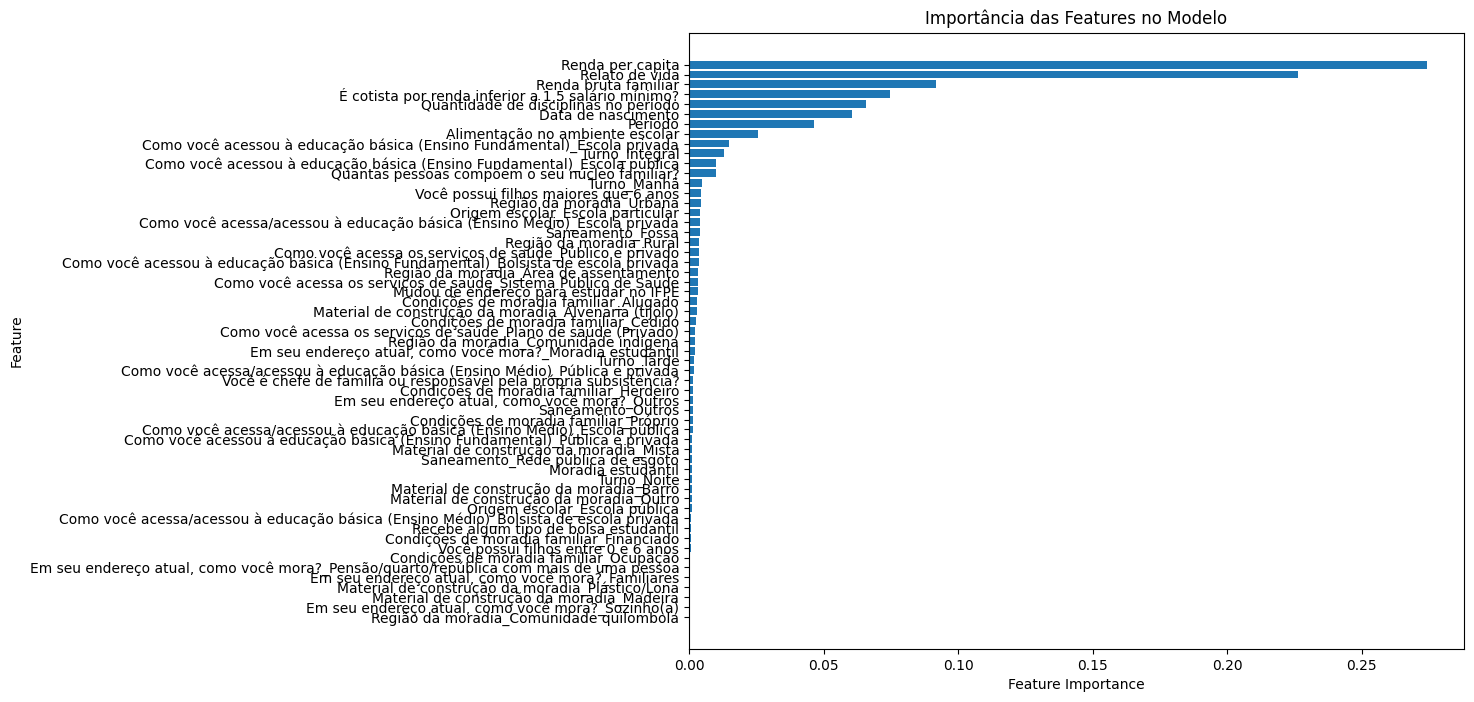

In [213]:
importance = model.feature_importances_

# Converter em DataFrame para facilitar a visualização
importance_df = pd.DataFrame({
    'Feature': X_train_unormalized.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plotar a importância das features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Importância das Features no Modelo")
plt.gca().invert_yaxis()  # Inverter a ordem para que a feature mais importante apareça no topo
plt.show()

#### Teste

In [214]:
class_labels = model.classes_
print(class_labels)

[False  True]


In [215]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba

array([[0.09018891, 0.90981109],
       [0.07160987, 0.92839013],
       [0.11715287, 0.88284713],
       ...,
       [0.08034928, 0.91965072],
       [0.27802733, 0.72197267],
       [0.21462285, 0.78537715]])

In [216]:
y_pred = model.predict(X_test)

In [217]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8197492163009404
Precision: 0.791014946479587
Recall: 0.8197492163009404


In [218]:
get_overall_metrics(y_test, y_pred)

{'acc': 0.8197492163009404,
 'tpr': 0.994234465086483,
 'fpr': 0.9518413597733711,
 'precision': 0.8220338983050848,
 'f1-score': 0.8999710060887214}

### Cross Batch Model (XBM)

#### Treinamento

In [180]:
model = XGBClassifier(
    objective='binary:logistic',  # Problema de classificação binária
    booster='gbtree',             # Tipo de booster
    n_estimators=100,             # Número de árvores
    learning_rate=0.178,            # Taxa de aprendizado
    max_depth=6,                  # Profundidade máxima das árvores
    min_child_weight=10,           # Peso mínimo da criança
    gamma=0.5,                      # Redução mínima na função de perda para fazer uma divisão
    subsample=0.8,                # Fração de amostras usadas para ajustar cada árvore
    colsample_bytree=0.8,         # Fração de características usadas para cada árvore            
    alpha=1,                      # Regularização L1
    scale_pos_weight=1           # Peso para a classe positiva
    #random_state=RANDOM_SEED               # Semente para reprodutibilidade
    #n_jobs=6
)

In [181]:
model.fit(X_train, y_train)

XGBClassifier(alpha=1, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.178, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

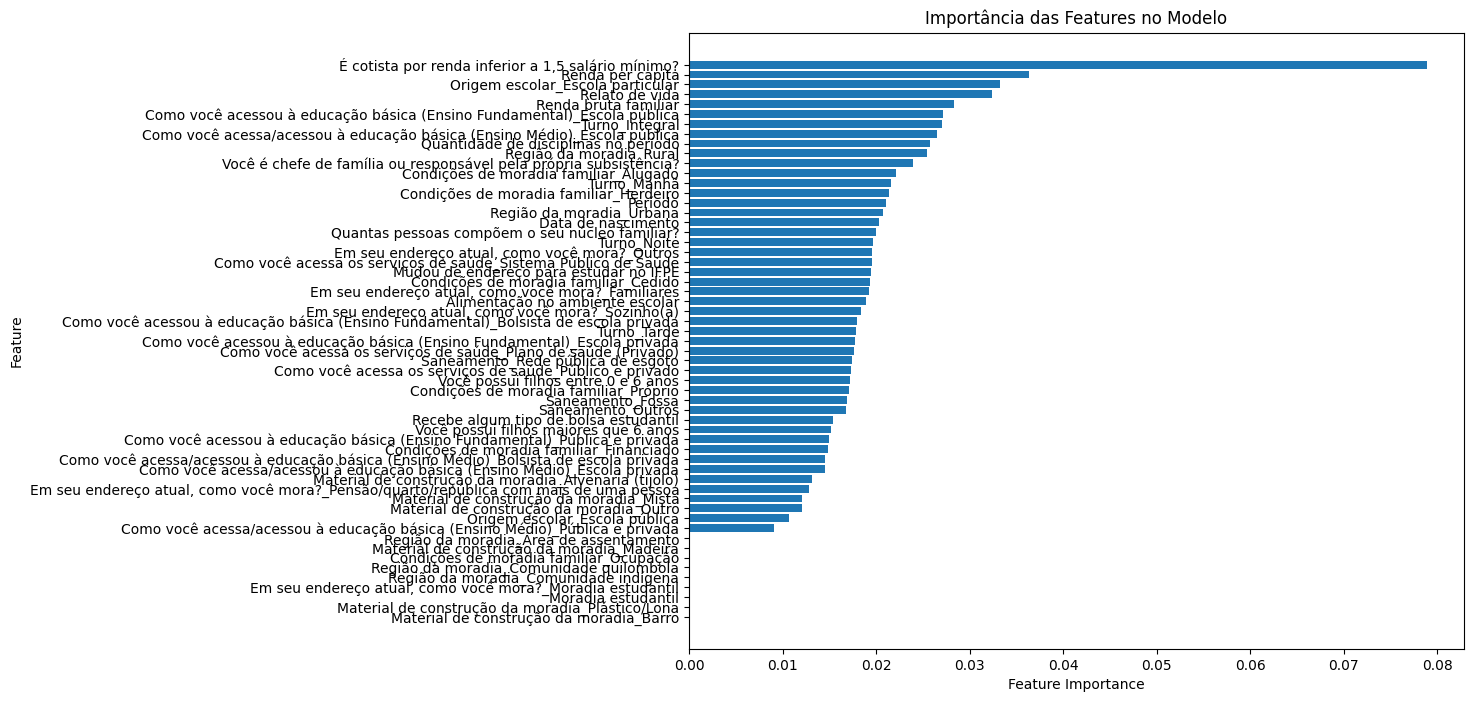

In [182]:
importance = model.feature_importances_

# Converter em DataFrame para facilitar a visualização
importance_df = pd.DataFrame({
    'Feature': X_train_unormalized.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plotar a importância das features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Importância das Features no Modelo")
plt.gca().invert_yaxis()  # Inverter a ordem para que a feature mais importante apareça no topo
plt.show()

#### Teste

In [183]:
y_pred_proba = model.predict_proba(X_test)

In [184]:
y_pred = model.predict(X_test)

In [185]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8145245559038663
Precision: 0.7633248630505685
Recall: 0.8145245559038663


In [186]:
get_overall_metrics(y_test, y_pred)

{'acc': 0.8145245559038663,
 'tpr': 0.9782190903267136,
 'fpr': 0.9093484419263456,
 'precision': 0.8262987012987013,
 'f1-score': 0.8958638897037254}

## Modelos de aprendizagem profunda

### Rede neural simples (MLP)

#### Treinamento

In [187]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Camada de entrada com 1536 neurônios
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [188]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [189]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

In [190]:
model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/300
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.7946 - loss: 0.5262 - val_accuracy: 0.8125 - val_loss: 0.4641
Epoch 2/300
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.8199 - loss: 0.4705 - val_accuracy: 0.8134 - val_loss: 0.4561
Epoch 3/300
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.8156 - loss: 0.4574 - val_accuracy: 0.8142 - val_loss: 0.4533
Epoch 4/300
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.8283 - loss: 0.4383 - val_accuracy: 0.8151 - val_loss: 0.4515
Epoch 5/300
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.8167 - loss: 0.4514 - val_accuracy: 0.8136 - val_loss: 0.4501
Epoch 6/300
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.8216 - loss: 0.4398 - val_accuracy: 0.8151 - val_loss: 0.4492
Epoch 7/300
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.8176 - loss: 0.4475 - val_accuracy: 0.8154 - val_loss: 0.4485
Epoch 8/300
431/431 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.8256 - loss: 0

#### Teste

In [191]:
y_pred_proba = model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


In [192]:
y_pred = transform_prob_in_pred(y_pred_proba)

In [193]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8171368861024033
Precision: 0.7846489978151421
Recall: 0.8171368861024033


In [194]:
get_overall_metrics(y_test, y_pred)

{'acc': 0.8171368861024033,
 'tpr': 0.9974375400384369,
 'fpr': 0.9801699716713881,
 'precision': 0.8181818181818182,
 'f1-score': 0.8989607390300232}

## Aprendizagem de máquina automática (AutoML)

### Tpot

In [195]:
#tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20)
#tpot.fit(X_train, y_train)

In [196]:
#print(tpot.score(X_test, y_test))

# Ordenação do dataframe

Modelo escolhido: GBM

In [197]:
model = GradientBoostingClassifier(
    n_estimators= 50,
    learning_rate= 0.09,
    max_depth= 4,
    min_samples_split= 2,
    min_samples_leaf= 1,
    subsample= 0.5
    )#, random_state=RANDOM_SEED)

In [198]:
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.09, max_depth=4, n_estimators=50,
                           subsample=0.5)

In [199]:
y_pred_proba = model.predict_proba(df)

In [200]:
y_pred = model.predict(df)

In [203]:
df['Nível de necessidade'] = y_pred_proba[:, 1]

In [204]:
df_result = df.sort_values(by='Nível de necessidade', ascending=False)

In [205]:
df_result.reset_index(drop=True, inplace=True)

In [207]:
df_result

,Alimentação no ambiente escolar,Como você acessa os serviços de saúde_Plano de saúde (Privado),Como você acessa os serviços de saúde_Público e privado,Como você acessa os serviços de saúde_Sistema Público de Saúde,Como você acessa/acessou à educação básica (Ensino Médio)_Bolsista de escola privada,Como você acessa/acessou à educação básica (Ensino Médio)_Escola privada,Como você acessa/acessou à educação básica (Ensino Médio)_Escola pública,Como você acessa/acessou à educação básica (Ensino Médio)_Pública e privada,Como você acessou à educação básica (Ensino Fundamental)_Bolsista de escola privada,Como você acessou à educação básica (Ensino Fundamental)_Escola privada,...,Saneamento_Rede pública de esgoto,Turno_Integral,Turno_Manhã,Turno_Noite,Turno_Tarde,Você possui filhos entre 0 e 6 anos,Você possui filhos maiores que 6 anos,Você é chefe de família ou responsável pela própria subsistência?,"É cotista por renda inferior a 1,5 salário mínimo?",Nível de necessidade
0,45.0,False,False,True,False,False,True,False,False,False,...,False,True,False,False,False,0,0,False,False,0.899007
1,30.0,False,False,True,False,False,True,False,False,False,...,False,True,False,False,False,0,0,False,True,0.894457
2,10.0,False,False,True,False,True,False,False,False,False,...,False,False,True,False,False,0,0,False,True,0.892353
3,10.0,False,False,True,False,False,True,False,False,False,...,False,False,True,False,False,0,0,True,False,0.889851
4,0.0,False,False,True,False,False,True,False,False,False,...,False,True,False,False,False,0,0,False,False,0.889565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19131,0.0,True,False,False,False,False,True,False,False,True,...,True,False,False,True,False,0,0,False,True,0.046778
19132,0.0,False,False,True,False,False,True,False,False,True,...,True,False,False,False,True,0,0,False,True,0.046778
19133,0.0,False,False,True,False,False,True,False,False,True,...,True,False,False,False,True,0,0,False,True,0.046778
19134,0.0,False,False,True,False,False,True,False,False,True,...,True,False,False,False,True,0,0,False,True,0.046778


In [208]:
df

,Alimentação no ambiente escolar,Como você acessa os serviços de saúde_Plano de saúde (Privado),Como você acessa os serviços de saúde_Público e privado,Como você acessa os serviços de saúde_Sistema Público de Saúde,Como você acessa/acessou à educação básica (Ensino Médio)_Bolsista de escola privada,Como você acessa/acessou à educação básica (Ensino Médio)_Escola privada,Como você acessa/acessou à educação básica (Ensino Médio)_Escola pública,Como você acessa/acessou à educação básica (Ensino Médio)_Pública e privada,Como você acessou à educação básica (Ensino Fundamental)_Bolsista de escola privada,Como você acessou à educação básica (Ensino Fundamental)_Escola privada,...,Saneamento_Rede pública de esgoto,Turno_Integral,Turno_Manhã,Turno_Noite,Turno_Tarde,Você possui filhos entre 0 e 6 anos,Você possui filhos maiores que 6 anos,Você é chefe de família ou responsável pela própria subsistência?,"É cotista por renda inferior a 1,5 salário mínimo?",Nível de necessidade
0,25.0,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,0,0,False,False,0.310202
1,0.0,False,False,True,False,False,True,False,False,False,...,True,False,False,True,False,0,0,True,True,0.131648
2,0.0,False,False,True,False,False,True,False,False,False,...,False,True,False,False,False,0,3,False,False,0.756957
3,70.0,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,0,0,False,False,0.460271
4,0.0,False,False,True,False,False,True,False,False,False,...,True,False,False,False,True,0,1,False,True,0.151776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19131,45.0,True,False,False,False,True,False,False,False,True,...,True,False,False,False,True,0,0,False,False,0.282675
19132,0.0,False,False,True,False,False,True,False,False,False,...,True,False,False,False,True,0,0,False,True,0.265224
19133,10.0,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,0,2,True,True,0.116964
19134,40.0,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,0,0,True,True,0.073356


In [219]:
dump(model, f'../models/GBM_{len(df.columns)}c_a{accuracy}.joblib')

['../models/GBM_58c_a0.8197492163009404.joblib']

In [220]:
dump(scaler, f'../models/scalers/std_scaler_GBM_{len(df.columns)}c_a{accuracy}.pkl')

['../models/scalers/std_scaler_GBM_58c_a0.8197492163009404.pkl']

In [222]:
dump(model_text, f'../models/spacy_model_LR.joblib')

['../models/spacy_model_LR.joblib']